## Detrend and explain action measure code
Using daily data: First detrend the data using seasonal decomposition or fast fourier transform. Then a Gaussian normal distribution curve is fit over which the 90th percentile is calculated. Then the  is defined which is the integral of exceedance (Tmax from 90th percentile) over the duration of three or more consecutive days.

In [1]:
from netCDF4 import Dataset
import cartopy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
import xarray as xr

### Prepare and find dataset
daily_tas_hist = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_historical_r1i1p1f2_gn_19500101-20141230.nc' daily_tas_fut1 = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20150101-20491230.nc' daily_tas_fut2 = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20500101-21001230.nc'

!cdo mergetime /badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_historical_r1i1p1f2_gn_19500101-20141230.nc /badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20150101-20491230.nc delete_all.nc !cdo mergetime delete_all.nc /badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20500101-21001230.nc daily_merged.nc

lat_bnds, lon_bnds = [20, 27], [86, 95]
!cdo sellonlatbox,86,95,20,27 daily_merged.nc daily_tas_merged.nc

In [2]:
tas_daily_hist_fut = xr.open_dataset('daily_tas_merged.nc')

## Explanation of calculate_action_measure_grid function below
First, the large grid dataset containing all points is broken up into individual points in order to perform calculations separately and to set separate standards for the points.

In [3]:
def breakup_grids(filename, lon, lat):
    number_lat = np.shape(filename["tas"]["lat"])[0]
    number_lon = np.shape(filename["tas"]["lon"])[0]
    
    save_grid_points = []
    for grid_lat in range(number_lat):
        latitude = filename["tas"]["lat"].values[grid_lat]
        for grid_lon in range(number_lon):
            longitude = filename["tas"]["lon"].values[grid_lon]
            one_point = filename["tas"].sel(lat=latitude,
                                                lon=longitude)
            save_grid_points.append([[longitude, latitude], one_point])
            if longitude == lon and latitude == lat:
                one_point.plot.line()
                plt.show()
    return save_grid_points

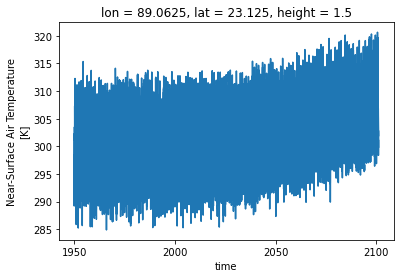

In [4]:
grid_points_hist_fut = breakup_grids(tas_daily_hist_fut, 89.0625, 23.125)

In [5]:
temperature_data = grid_points_hist_fut[0][1]

## Detrend dataset
Then, the dataset is detrended using a 10 year period.

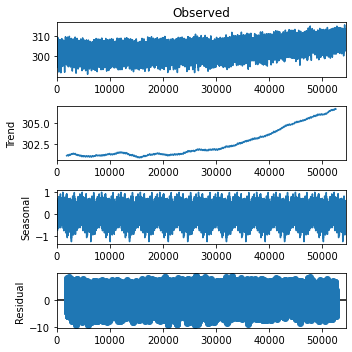

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(temperature_data, model='additive', period=3650)
trend = decomposition.trend
plt.rcParams.update({'figure.figsize': (5,5)})
decomposition.plot()
plt.show()

In [7]:
# subtract the trend from the dataset and create a new dataframe
daily_temp_nt = temperature_data.values - trend
daily_NT = temperature_data.copy()
daily_NT.data = daily_temp_nt

In [8]:
# calculate the relative temperature and the 90th percentile
p = np.nanpercentile(daily_NT, 90)
p

3.967706529591231

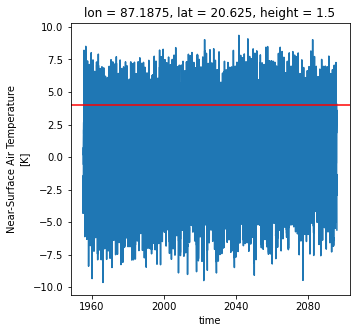

In [9]:
daily_NT.plot()
plt.axhline(y=p, color='r', linestyle='-')
plt.show()

## Define and calculate action measure,
Defined as temperature above a certain threshold for 3 or more days

In [10]:
from scipy import integrate
import scipy

In [11]:
action_measure_list = [0,0]
included_days = []

for i in range(2, len(daily_NT.values)):
    if i in included_days:
        continue
    else:
        temperature_day = daily_NT.values[i]
        if temperature_day > p:
            # find duration of event
            j = i - 2
            duration_count = 0
            while daily_NT.values[j] > p:
                j += 1
                duration_count += 1
            # if event lasts for 3 days or more, we'll find the action measure
            if duration_count  >= 3:
                # slice data and calculate how much it exceeds threshold
                exceedances = [k - p for k in daily_NT.data[(i-2):(i+duration_count-2)]]
                # find action measure by integration
                actionmeasure = scipy.integrate.trapezoid(exceedances, x=None, dx=1.0, axis=- 1)
                included_days.extend(list(range(i, i+duration_count-2)))
                # include all days
                action_measure_list[-2:] = [actionmeasure]*2
                action_measure_list.extend([actionmeasure for i in range(duration_count-2)])
            else: 
                action_measure_list.append(0)
        else: 
            action_measure_list.append(0)

In [12]:

action_measure = daily_NT.copy()
action_measure.data = action_measure_list
action_measure.rename('action_measure')

<xarray.DataArray 'action_measure' (time: 54360)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-30 12:00:00
    lon      float64 87.19
    lat      float64 20.62
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    comment:        near-surface (usually, 2 meter) air temperature
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-25T11:32:40Z altered by CMOR: Treated scalar dime...

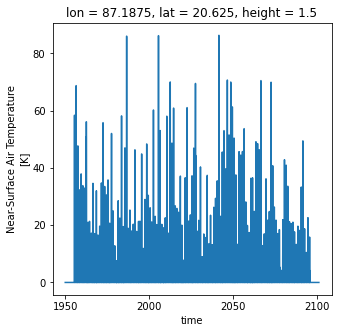

In [13]:
action_measure.plot()

## The function covering everything
The calculate_action_measure_grid function evaluates every grid and finds the values of where to set the threshold

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import integrate
import scipy

In [ ]:
def calculate_action_measure_list(daily_NT, p):
    action_measure_list = [0,0]
    included_days = []

    for i in range(2, len(daily_NT.values)):
        if i in included_days:
            continue
        else:
            temperature_day = daily_NT.values[i]
            if temperature_day > p:
                # find duration of event
                j = i - 2
                duration_count = 0
                while daily_NT.values[j] > p:
                    j += 1
                    duration_count += 1
                # if event lasts for 3 days or more, we'll find the action measure
                if duration_count  >= 3:
                    # slice data and calculate how much it exceeds threshold
                    exceedances = [k - p for k in daily_NT.data[(i-2):(i+duration_count-2)]]
                    # find action measure by integration
                    actionmeasure = scipy.integrate.trapezoid(exceedances, x=None, dx=1.0, axis=- 1)
                    included_days.extend(list(range(i, i+duration_count-2)))
                    # include all days
                    action_measure_list[-2:] = [actionmeasure]*2
                    action_measure_list.extend([actionmeasure for i in range(duration_count-2)])
                else: 
                    action_measure_list.append(0)
            else: 
                action_measure_list.append(0)
    return action_measure_list

In [16]:
def calculate_action_measures_grid(filename):
    # break temperature data up in grids
    number_lat = np.shape(filename["tas"]["lat"])[0]
    number_lon = np.shape(filename["tas"]["lon"])[0]
    
    save_grid_points = []
    for grid_lat in range(number_lat):
        latitude = filename["tas"]["lat"].values[grid_lat]
        for grid_lon in range(number_lon):
            longitude = filename["tas"]["lon"].values[grid_lon]
            one_point = filename["tas"].sel(lat=latitude,
                                                lon=longitude)
            save_grid_points.append([[longitude, latitude], one_point])

    # decompose save_grid_points
    action_measure_dataset = []
    for datafile in save_grid_points:
        decomposition = seasonal_decompose(datafile[1], model='additive', period=3650)
        trend = decomposition.trend

        daily_temp_nt = datafile[1].values - trend
        daily_NT = datafile[1].copy()
        daily_NT.data = daily_temp_nt
        p = np.nanpercentile(daily_NT, 90)
        
        # calculate action measure in datalist
        action_measure_list = calculate_action_measure_list(daily_NT, p)

        coords = {'time': (np.array(datafile[1]['time'].data))
         }

        # define global attributes
        attrs = {'author':'Lisanne Blok'}

        # create dataset
        action_measure_array = xr.DataArray(action_measure_list,
                                            dims = ['time'],
                                coords=coords, 
                                attrs=attrs)

        lon_list = (np.array(datafile[1]['lon'].data))
        lat_list = (np.array((datafile[1]['lat'].data)))
        
        action_measure_array["lon"] = lon_list
        action_measure_array["lat"] = lat_list
        
        action_measure_array = action_measure_array.expand_dims("lat")
        action_measure_array = action_measure_array.expand_dims("lon")
        
        action_measure_array = action_measure_array.transpose("time", "lon", "lat")
        
        action_measure_dataset.append(action_measure_array)

    return action_measure_dataset

In [17]:
action_measure_data_sets = calculate_action_measures_grid(tas_daily_hist_fut)

In [18]:
am_daily = xr.combine_by_coords(action_measure_data_sets)

In [19]:
am_daily = am_daily.to_dataset(name = "actionmeasure")

In [25]:
# Save am_daily file as nc file
new_filename_1 = 'output/am_bang_daily.nc'
am_daily.to_netcdf(path=new_filename_1)

## Spatial plots


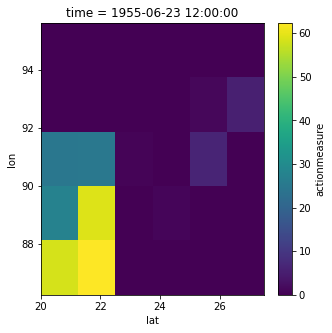

In [20]:
# limit vanaf 0
am_daily.actionmeasure.isel(time = 1972).plot()

Text(0.5, 1.0, 'Mean of action measure over time')

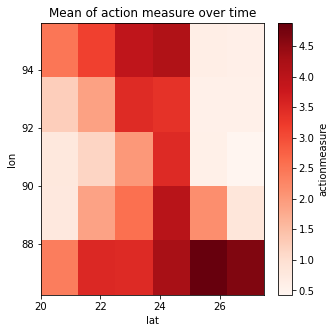

In [21]:
raph = am_daily['actionmeasure']
over_time = raph.mean(dim = 'time')
over_time.plot(cmap = 'Reds')
plt.title('Mean of action measure over time')

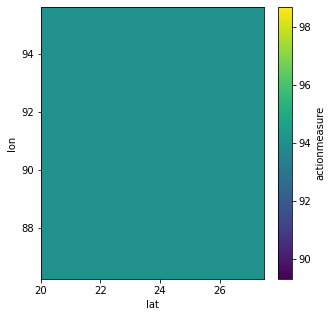

In [22]:
a = raph.where(raph > 0)
hallo = a.dropna(dim = 'time')
hallo = hallo.count(dim='time')
hallo.plot()

Text(0.5, 1.0, 'Standard deviation')

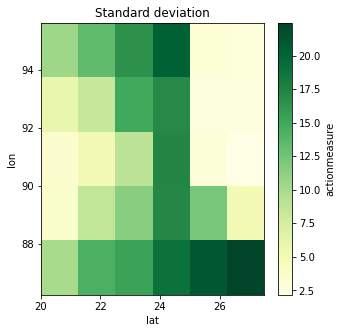

In [23]:
std = raph.std(dim = 'time')
std.plot(cmap = 'YlGn')
plt.title('Standard deviation')

Text(0.5, 1.0, 'Maximum value of action measure')

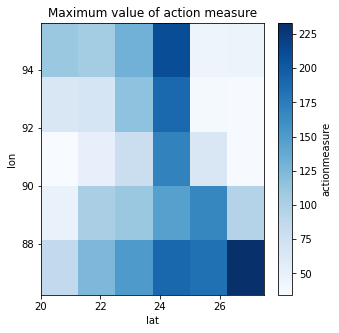

In [24]:
max_plt = raph.max(dim = 'time')
max_plt.plot(cmap = 'Blues')
plt.title('Maximum value of action measure')